<a href="https://colab.research.google.com/github/bitanb1999/Yelp/blob/main/ProjectRough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
#Import libraries
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
import sklearn.metrics
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

#THE BUSINESS DATASET:

In [16]:
restaurants=pd.read_pickle('../restaurants_df')
restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
24,eBEfgOPG7pvFhb2wcG9I7w,Philthy Phillys,"15480 Bayview Avenue, unit D0110",Aurora,ON,L4G 7J1,44.010962,-79.448677,4.5,4,1,"{'RestaurantsTableService': 'False', 'Restaura...","Restaurants, Cheesesteaks, Poutineries","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
38,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,843 Kipling Avenue,Toronto,ON,M8Z 5G9,43.633291,-79.531768,3.0,13,0,"{'RestaurantsPriceRange2': '2', 'RestaurantsAt...","Restaurants, Burgers, Food",None
41,98hyK2QEUeI8v2y0AghfZA,Pho Lee's Vietnamese Restaurant,"1541 E 38th St, Ste 101",Cleveland,OH,44114,41.512155,-81.663332,4.5,23,1,"{'BusinessParking': 'None', 'Ambience': '{'tou...","Restaurants, Vietnamese, Soup","{'Monday': '11:0-20:0', 'Wednesday': '11:0-20:..."
43,LoRef3ChgZKbxUio-sHgQg,Amir,5252 Rue Jean Talon O,Montréal,QC,H4P 2A7,45.494870,-73.651904,3.0,18,1,"{'RestaurantsAttire': 'u'casual'', 'Restaurant...","Restaurants, Lebanese, Middle Eastern",None
49,tLpkSwdtqqoXwU0JAGnApw,Wendy's,4602 Northfield Road,Cleveland,OH,44128,41.434614,-81.527026,3.5,7,1,"{'RestaurantsDelivery': 'False', 'BusinessAcce...","Restaurants, Fast Food, Burgers","{'Monday': '10:0-3:0', 'Tuesday': '10:0-3:0', ..."


In [17]:
restaurants=restaurants.drop(['address','hours'],axis=1)

In [18]:
restaurants.groupby("city").count().sort_values("name",ascending=False)

,business_id,name,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories
city,,,,,,,,,,,
Toronto,2707,2707,2707,2707,2707,2707,2707,2707,2707,2596,2707
Las Vegas,2006,2006,2006,2006,2006,2006,2006,2006,2006,1985,2006
Phoenix,1347,1347,1347,1347,1347,1347,1347,1347,1347,1326,1347
Montréal,1286,1286,1286,1286,1286,1286,1286,1286,1286,1219,1286
Calgary,894,894,894,894,894,894,894,894,894,845,894
...,...,...,...,...,...,...,...,...,...,...,...
Moon Twp,1,1,1,1,1,1,1,1,1,1,1
Moreland Hills,1,1,1,1,1,1,1,1,1,1,1
Mount Royal,1,1,1,1,1,1,1,1,1,1,1


Using the restaurants of the dataset which are of the Toronto City:

In [19]:
restaurants=restaurants[restaurants.city=='Toronto']
restaurants.head()

,business_id,name,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories
38,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,Toronto,ON,M8Z 5G9,43.633291,-79.531768,3.0,13,0,"{'RestaurantsPriceRange2': '2', 'RestaurantsAt...","Restaurants, Burgers, Food"
277,d9A5lhFHOBvEw-BxSYnWOA,Song Cook's Corean Chilli,Toronto,ON,M6G 1L3,43.663746,-79.416452,4.0,4,0,"{'HasTV': 'True', 'WiFi': 'u'no'', 'Restaurant...","Restaurants, Korean"
327,37kk0IW6jL7ZlxZF6k2QBg,Edulis,Toronto,ON,M5V,43.641948,-79.406580,4.0,115,1,"{'RestaurantsGoodForGroups': 'False', 'Restaur...","Restaurants, Spanish, French"
332,y1Er-SodAde9QZIcgFf45g,Blackod Steak and Fish House,Toronto,ON,M4N 2N3,43.734367,-79.404422,2.0,8,0,"{'GoodForKids': 'True', 'OutdoorSeating': 'Fal...","Restaurants, Steakhouses, Seafood"
354,0rMFhLzeq3Z2OaJ62MQXlw,Spiga Ristorante,Toronto,ON,M4T 1Y5,43.686247,-79.393561,4.0,14,1,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, Italian"


In [20]:
restaurants.shape

(2707, 12)

In [21]:
restaurants=restaurants.drop(['city','state'],axis=1)

In [22]:
restaurants.isna().sum()

business_id       0
name              0
postal_code       0
latitude          0
longitude         0
stars             0
review_count      0
is_open           0
attributes      111
categories        0
dtype: int64

In [23]:
def atomicrows(df,target_column):

    def splitListToRows(row,row_accumulator,target_column):

        new_row = row.to_dict()
        
        try:
            split_row = row[target_column]['Ambience'].replace('\'', "").replace('{','').replace('}','').split(",")
        
            for i in split_row:

                if i is None:
                    
                    continue
                
                try:

                    new_row["amb_"+i.split(":")[0].strip()] = i.split(":")[1].replace('\'', "").strip()
                    
                except:

                    f = 0

        except:

            f = 1

        row_accumulator.append(new_row)

    new_rows = [] 
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column))
    new_df = pd.DataFrame(new_rows)
    return new_df



In [24]:
restaurants = atomicrows(restaurants,'attributes')

restaurants.shape

(2707, 19)

In [25]:
restaurants.isna().sum()

business_id        0
name               0
postal_code        0
latitude           0
longitude          0
stars              0
review_count       0
is_open            0
attributes       111
categories         0
amb_romantic     591
amb_intimate     591
amb_classy       591
amb_hipster      689
amb_divey       1837
amb_touristy     591
amb_trendy       591
amb_upscale      597
amb_casual       591
dtype: int64

In [26]:
 restaurants.columns[10:]

Index(['amb_romantic', 'amb_intimate', 'amb_classy', 'amb_hipster', 'amb_divey', 'amb_touristy', 'amb_trendy', 'amb_upscale', 'amb_casual'], dtype='object')

In [27]:
amb_cols = restaurants.columns[10:]

restaurants[amb_cols] = restaurants[amb_cols].fillna('False')

for i in amb_cols:
    restaurants[i].replace('None','False',inplace=True)

In [28]:
restaurants[amb_cols[0]].unique()

array(['False', 'True'], dtype=object)

In [29]:
restaurants.isna().sum()

business_id       0
name              0
postal_code       0
latitude          0
longitude         0
stars             0
review_count      0
is_open           0
attributes      111
categories        0
amb_romantic      0
amb_intimate      0
amb_classy        0
amb_hipster       0
amb_divey         0
amb_touristy      0
amb_trendy        0
amb_upscale       0
amb_casual        0
dtype: int64

In [30]:
restaurants.shape

(2707, 19)

In [31]:
restaurants.to_pickle('toronto_restaurant')


In [86]:
restaurants = pd.read_pickle('toronto_restaurant')

In [87]:
restaurants=restaurants[restaurants.attributes.notnull()]

restaurants.shape

(2596, 19)

Flattening out the attributes column of the dataset to get hold of the latent factors:

In [88]:
res=pd.DataFrame()
for i in range(len(restaurants.attributes)):
  c=0
  d={}
  dict_=restaurants.iloc[i].attributes
  d['business_id']=restaurants.iloc[i]['business_id']
  d['name']=restaurants.iloc[i]['name']
  d['postal_code']=restaurants.iloc[i]['postal_code']
  d['latitude']=restaurants.iloc[i]['latitude']
  d['longitude']=restaurants.iloc[i]['longitude']
  d['stars']=restaurants.iloc[i]['stars']
  d['review_count']=restaurants.iloc[i]['review_count']
  d['is_open']=restaurants.iloc[i]['is_open']
  d['categories']=restaurants.iloc[i]['categories']

  d['amb_romantic']= restaurants.iloc[i]['amb_romantic']
  d['amb_intimate']= restaurants.iloc[i]['amb_intimate']
  d['amb_classy']= restaurants.iloc[i]['amb_classy']
  d['amb_hipster']= restaurants.iloc[i]['amb_hipster']
  d['amb_divey']= restaurants.iloc[i]['amb_divey']
  d['amb_touristy']= restaurants.iloc[i]['amb_touristy']
  d['amb_trendy']= restaurants.iloc[i]['amb_trendy']
  d['amb_upscale']= restaurants.iloc[i]['amb_upscale']
  d['amb_casual']= restaurants.iloc[i]['amb_casual']

  for key,value in dict_.items():
    d[key]=value
  
  
  d=pd.DataFrame(d,columns=d.keys(),index=[i])
  res=pd.concat([res,d])

  

In [89]:
res

,business_id,name,postal_code,latitude,longitude,stars,review_count,is_open,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsPriceRange2,RestaurantsAttire,Alcohol,Caters,HasTV,GoodForKids,RestaurantsGoodForGroups,RestaurantsTakeOut,RestaurantsDelivery,RestaurantsReservations,BusinessParking,NoiseLevel,WiFi,Ambience,OutdoorSeating,BikeParking,GoodForMeal,RestaurantsTableService,WheelchairAccessible,DogsAllowed,HappyHour,DriveThru,Music,BestNights,BYOB,Corkage,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,ByAppointmentOnly,DietaryRestrictions,BusinessAcceptsBitcoin,RestaurantsCounterService
0,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,M8Z 5G9,43.633291,-79.531768,3.0,13,0,"Restaurants, Burgers, Food",False,False,False,False,False,False,False,False,True,2,u'casual',u'none',False,False,True,True,True,False,False,"{'garage': False, 'street': False, 'validated'...",u'average','no',"{'romantic': False, 'intimate': False, 'classy...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,d9A5lhFHOBvEw-BxSYnWOA,Song Cook's Corean Chilli,M6G 1L3,43.663746,-79.416452,4.0,4,0,"Restaurants, Korean",False,False,False,False,False,False,False,False,False,1,u'casual',NaN,False,True,True,True,True,True,True,"{'garage': False, 'street': False, 'validated'...",u'average',u'no',"{'romantic': False, 'intimate': False, 'classy...",False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,37kk0IW6jL7ZlxZF6k2QBg,Edulis,M5V,43.641948,-79.406580,4.0,115,1,"Restaurants, Spanish, French",True,True,True,False,False,False,False,False,False,4,u'casual',u'full_bar',False,True,False,False,False,False,True,"{'garage': False, 'street': True, 'validated':...",u'average',u'no',"{'touristy': False, 'hipster': False, 'romanti...",True,True,"{'dessert': False, 'latenight': False, 'lunch'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,y1Er-SodAde9QZIcgFf45g,Blackod Steak and Fish House,M4N 2N3,43.734367,-79.404422,2.0,8,0,"Restaurants, Steakhouses, Seafood",False,False,False,False,False,False,False,False,False,3,u'casual',u'full_bar',NaN,True,True,True,NaN,NaN,True,"{'garage': False, 'street': False, 'validated'...",u'quiet',NaN,"{'touristy': False, 'hipster': False, 'romanti...",False,NaN,"{'dessert': False, 'latenight': False, 'lunch'...",True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0rMFhLzeq3Z2OaJ62MQXlw,Spiga Ristorante,M4T 1Y5,43.686247,-79.393561,4.0,14,1,"Restaurants, Italian",False,False,False,False,False,False,False,False,False,3,u'casual',u'full_bar',NaN,True,True,True,True,True,True,"{'garage': False, 'street': False, 'validated'...",u'average',u'no',"{'romantic': False, 'intimate': False, 'classy...",True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2591,undz-LtXIta312RP_DqmFQ,Subway,M5E 1T3,43.649047,-79.374216,4.0,4,1,"Restaurants, Fast Food, Sandwiches",False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,False,NaN,u'average',u'no',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2592,LrrJW6ejsVL7hADfFy87Eg,EatThai,M2N 5P7,43.770441,-79.412986,3.5,29,0,"Restaurants, Thai",False,False,False,False,False,False,False,False,True,2,u'casual','beer_and_wine',False,False,True,True,True,True,True,"{'garage': False, 'street': True, 'validated':...",u'average','no',"{'romantic': False, 'intimate': False, 'classy...",False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2593,9F_3PA1QBQ3aGI2RW2zMtw,Shawarma's King,M5H 3S6,43.647430,-79.386774,2.0,22,1,"Restaurants, Mediterranean",False,False,False,False,False,False,False,

Handling the nulls and modifying the Nans and categorising the columns in order to obtain the latent factor values:

In [90]:
res['RestaurantsPriceRange2']=res['RestaurantsPriceRange2'].replace(np.nan,0)
res['RestaurantsAttire']=res['RestaurantsAttire'].replace(np.nan,"streets")
res['Alcohol']=res['Alcohol'].replace(np.nan,"u'none'")
res['Caters']=res['Caters'].replace(np.nan,"False")
for i in res.columns[13:]:
  res[i]=res[i].replace(np.nan,"False")
res['BusinessParking']=res['BusinessParking'].apply(lambda x:'True'if "True" in x else "False")

res.drop('Ambience',axis=1)

res['GoodForMeal']=res['GoodForMeal'].astype('category').cat.codes.values

In [91]:
res['RestaurantsPriceRange2'].unique()

array(['2', '1', '4', '3', 0, 'None'], dtype=object)

In [92]:
for i in res.columns[9:]:
  res[i]=res[i].astype('category').cat.codes.values

In [93]:
res.head()

,business_id,name,postal_code,latitude,longitude,stars,review_count,is_open,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsPriceRange2,RestaurantsAttire,Alcohol,Caters,HasTV,GoodForKids,RestaurantsGoodForGroups,RestaurantsTakeOut,RestaurantsDelivery,RestaurantsReservations,BusinessParking,NoiseLevel,WiFi,Ambience,OutdoorSeating,BikeParking,GoodForMeal,RestaurantsTableService,WheelchairAccessible,DogsAllowed,HappyHour,DriveThru,Music,BestNights,BYOB,Corkage,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,ByAppointmentOnly,DietaryRestrictions,BusinessAcceptsBitcoin,RestaurantsCounterService
0,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,M8Z 5G9,43.633291,-79.531768,3.0,13,0,"Restaurants, Burgers, Food",0,0,0,0,0,0,0,0,1,2,5,6,0,0,2,2,2,0,0,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,d9A5lhFHOBvEw-BxSYnWOA,Song Cook's Corean Chilli,M6G 1L3,43.663746,-79.416452,4.0,4,0,"Restaurants, Korean",0,0,0,0,0,0,0,0,0,1,5,6,0,1,2,2,2,2,2,0,6,6,8,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,37kk0IW6jL7ZlxZF6k2QBg,Edulis,M5V,43.641948,-79.406580,4.0,115,1,"Restaurants, Spanish, French",1,1,1,0,0,0,0,0,0,4,5,5,0,1,0,0,0,0,2,1,6,6,83,2,2,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,y1Er-SodAde9QZIcgFf45g,Blackod Steak and Fish House,M4N 2N3,43.734367,-79.404422,2.0,8,0,"Restaurants, Steakhouses, Seafood",0,0,0,0,0,0,0,0,0,3,5,5,0,1,2,2,0,0,2,0,8,3,44,0,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0rMFhLzeq3Z2OaJ62MQXlw,Spiga Ristorante,M4T 1Y5,43.686247,-79.393561,4.0,14,1,"Restaurants, Italian",0,0,0,0,0,0,0,0,0,3,5,5,0,1,2,2,2,2,2,0,6,6,8,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [94]:
df = pd.Series(res['categories']).str.get_dummies(',')

In [98]:
df.columns = df.columns.str.strip()

df.drop(['Food','Restaurants'],axis=1,inplace=True)

df.shape

(2596, 216)

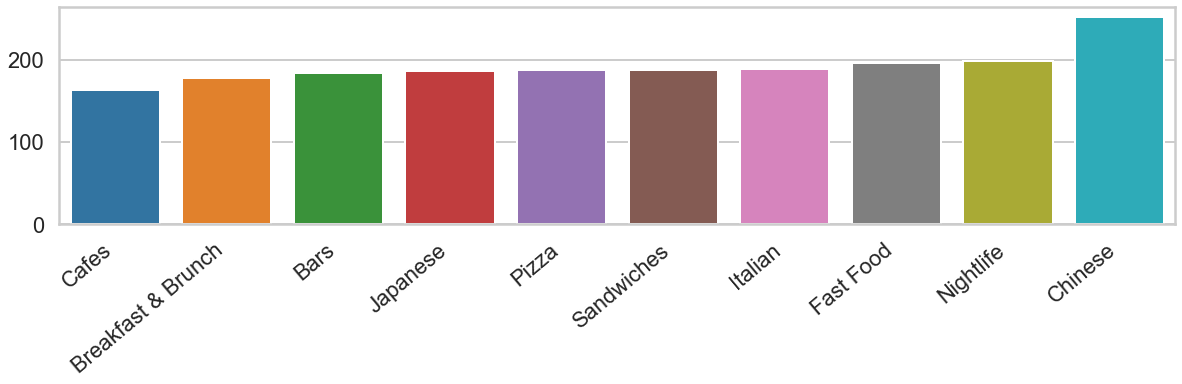

In [99]:
top_cats = df.sum().sort_values()[-10:]

plt.figure(figsize=(20,4))
ax = sns.barplot(top_cats.index,top_cats.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

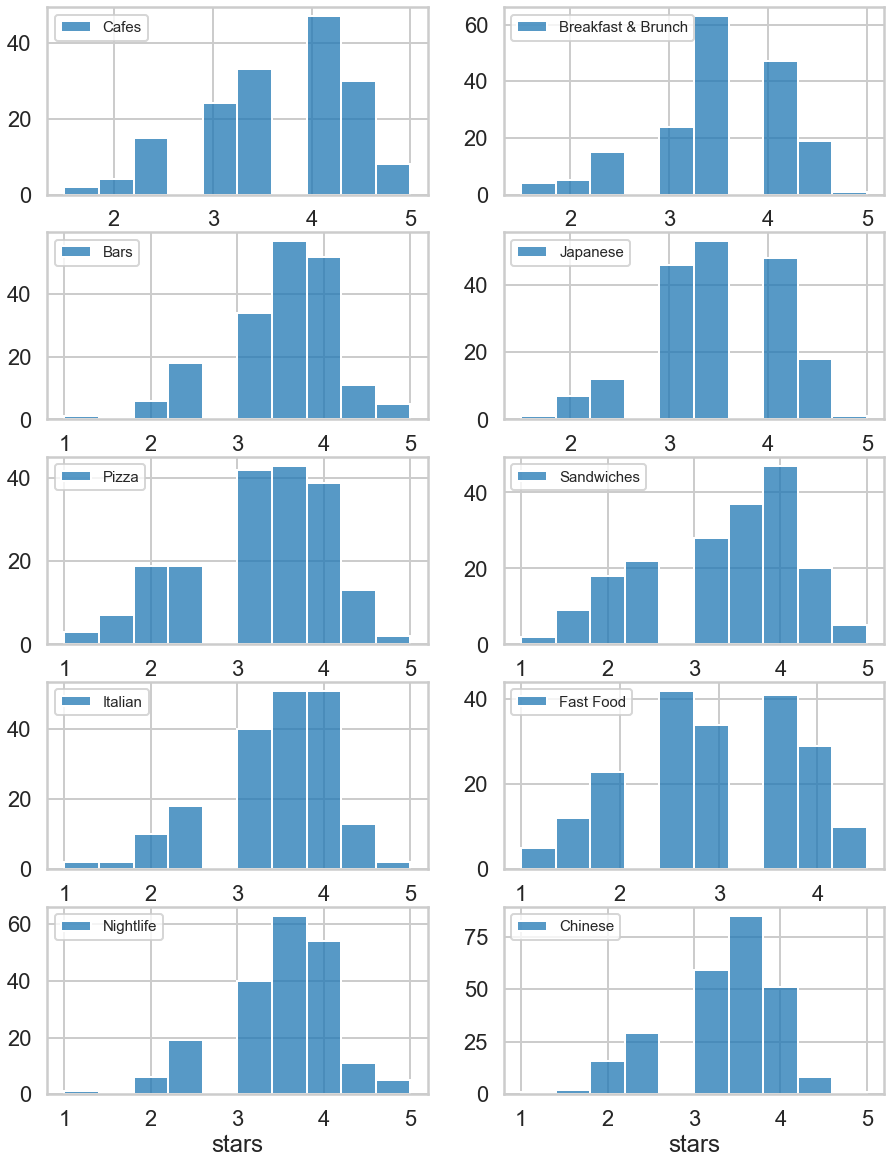

In [97]:
fig,axes = plt.subplots(nrows=5, ncols=2, figsize=(15,20))
axes = axes.flatten()
for i,x in enumerate(top_cats.index):

    sns.histplot(res.loc[df[df[x]==1].index]['stars'],bins=10,legend=True,ax=axes[i],label=x)
    axes[i].set(xlabel='stars', ylabel='')
    axes[i].legend(loc="upper left",fontsize=15)



<AxesSubplot:xlabel='is_open', ylabel='Count'>

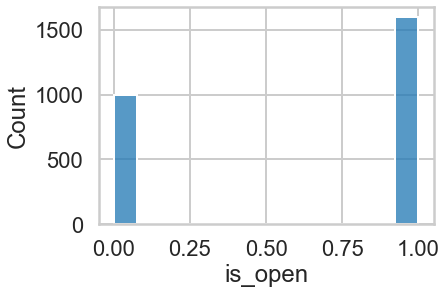

In [48]:
sns.histplot(res['is_open'])

<AxesSubplot:xlabel='stars'>

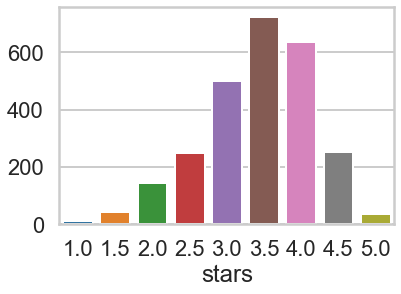

In [50]:
ratings = res.groupby('stars').count()['review_count']
sns.barplot(ratings.index,ratings.values)

<AxesSubplot:xlabel='review_count', ylabel='Count'>

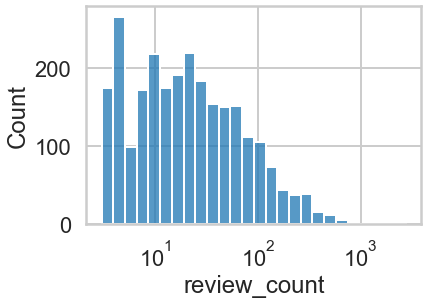

In [51]:
sns.histplot(res['review_count'],log_scale=True)

#MERGING WITH THE REVIEW DATASET:

In [71]:

reviews = []
with open('../yelp_dataset/yelp_academic_dataset_review.json', 'rb') as f:
    for i, line in enumerate(f):
        reviews.append(json.loads(line))

reviews = pd.DataFrame(reviews)


In [77]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


In [17]:
reviews=reviews.drop(['useful','funny','cool','date'],axis=1)

In [73]:
res=pd.merge(res,reviews,how="inner",on="business_id")

In [74]:
res=res.drop('review_id',axis=1)

In [75]:
res

,business_id,name,postal_code,latitude,longitude,stars_x,review_count,is_open,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsPriceRange2,RestaurantsAttire,Alcohol,Caters,HasTV,GoodForKids,RestaurantsGoodForGroups,RestaurantsTakeOut,RestaurantsDelivery,RestaurantsReservations,BusinessParking,NoiseLevel,WiFi,Ambience,OutdoorSeating,BikeParking,GoodForMeal,RestaurantsTableService,WheelchairAccessible,DogsAllowed,HappyHour,DriveThru,Music,BestNights,BYOB,Corkage,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,ByAppointmentOnly,DietaryRestrictions,BusinessAcceptsBitcoin,RestaurantsCounterService,user_id,stars_y,useful,funny,cool,text,date
0,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,M8Z 5G9,43.633291,-79.531768,3.0,13,0,"Restaurants, Burgers, Food",0,0,0,0,0,0,0,0,1,2,5,6,0,0,2,2,2,0,0,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,zsZVg16yjZu5NIiS0ayjrQ,5.0,0,1,0,"We've eaten here a few times now, and have bee...",2011-07-29 16:00:02
1,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,M8Z 5G9,43.633291,-79.531768,3.0,13,0,"Restaurants, Burgers, Food",0,0,0,0,0,0,0,0,1,2,5,6,0,0,2,2,2,0,0,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,r5CN1bIqkiRKS8LsV2nLrw,4.0,0,0,0,Good food. Lots of burger options that do not...,2014-10-14 23:06:37
2,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,M8Z 5G9,43.633291,-79.531768,3.0,13,0,"Restaurants, Burgers, Food",0,0,0,0,0,0,0,0,1,2,5,6,0,0,2,2,2,0,0,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,k9iqO8atK7BC4f8RcSXi-g,5.0,0,0,0,Love this place. I come here with my family ab...,2012-11-18 04:43:17
3,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,M8Z 5G9,43.633291,-79.531768,3.0,13,0,"Restaurants, Burgers, Food",0,0,0,0,0,0,0,0,1,2,5,6,0,0,2,2,2,0,0,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,wYVKG9TyR9ZUiTLSyEKepw,3.0,0,3,0,Make no mistake: this is a fast food joint. Ho...,2013-01-18 04:03:20
4,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,M8Z 5G9,43.633291,-79.531768,3.0,13,0,"Restaurants, Burgers, Food",0,0,0,0,0,0,0,0,1,2,5,6,0,0,2,2,2,0,0,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,v_jxdXocLOkid5CHOSEOow,1.0,1,0,0,What happened? Your burgers use to be the best...,2012-12-21 16:17:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124875,GAgEoHcf4PSuZRS5Zd3ltA,Q's Shawarma,M9W 4W6,43.701807,-79.575135,4.0,16,1,"Restaurants, Mediterranean",0,0,0,0,0,0,0,0,0,2,0,6,0,1,2,2,2,0,0,0,4,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,aSg4xC-7hRSM_27oBD58nw,1.0,1,0,0,This place is overrated. Expensive menu and me...,2017-05-16 23:27:55
124876,GAgEoHcf4PSuZRS5Zd3ltA,Q's Shawarma,M9W 4W6,43.701807,-79.575135,4.0,16,1,"Restaurants, Mediterranean",0,0,0,0,0,0,0,0,0,2,0,6,0,1,2,2,2,0,0,0,4,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SPX69i0ufD5UfJOSz49ysg,4.0,0,0,0,Surprising a nice place next to Gas station. P...,2019-08-08 20:37:34
124877,GAgEoHcf4PSuZRS5Zd3ltA,Q's Shawarma,M9W 4W6,43.701807,-79.575135,4.0,16,1,"Restaurants, Mediterranean",0,0,0,0,0,0,0,0,0,2,0,6,0,1,2,2,2,0,0,0,4,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,IlGVrBMNUnIjn7VzX67AyQ,5.0,0,0,0,"Amazing food, I got the hockey shawarma plate,...",2019-04-27 00:01:25
124878,GAgEoHcf4PSuZRS5Zd3ltA,Q's Shawarma,M9W 4W6,43.701807,-79.575135,4.0,16,1,"Restaurants, Mediterranean",0,0,0,0,0,0,0,0,0,2,0,6,0,1,2,2,2,0,0,0,4,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,qPx63cj5uzYqFzQYA_7W0w,1.0,1,0,0,Not sure what the hype about this place was. C...,2017-01-16 16:53:19


In [3]:
res.to_pickle('MERGEDBUSINESS',protocol=3)

In [103]:
res=pd.read_pickle('MERGEDBUSINESS')

###STEMMING AND FINDING OUT IF IT IS A GOOD REVIEW OR BAD:

In [104]:
X=res['text']

In [105]:
y_train=[1 if y>3.5 else 0 for y in res['stars_y']]

In [94]:
!pip install --upgrade pip
!pip install gensim
!pip install nltk

In [5]:
import gensim
from keras.preprocessing import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline


import re
from bs4 import BeautifulSoup

import nltk

In [6]:
def stemming(text):
    
    # stems each word in the review to it's root word
    stemmer = nltk.porter.PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [7]:
def pre_process_review(text):
  clean_review = BeautifulSoup(text).get_text()
  clean_review = clean_review.lower()
  clean_review =re.sub(('[^a-z\s]+')," ",clean_review)
  clean_review =re.sub(('\s+')," ",clean_review)
  stemming_review = stemming(clean_review)
  #print(stemming_review)
  return stemming_review

In [8]:
res['stemmed']=[pre_process_review(review) for review in X]

In [9]:
tokenizer = CountVectorizer(max_features = 100, stop_words = 'english')

In [10]:
train_tokenized = tokenizer.fit_transform(res['stemmed'])

In [11]:
train_tokenized=pd.DataFrame(train_tokenized.toarray(),columns=tokenizer.get_feature_names())


In [12]:
train_tokenized

,alway,amaz,ask,becaus,beef,befor,best,better,bit,burger,busi,came,chees,chicken,come,day,definit,delici,did,didn,dinner,dish,don,drink,eat,enjoy,everyth,experi,fish,flavour,food,fresh,fri,friend,friendli,good,got,great,ha,hot,just,know,like,littl,locat,look,lot,love,lunch,make,meal,meat,menu,nice,night,noodl,onli,order,peopl,pizza,place,pork,portion,pretti,price,quit,realli,recommend,restaur,rice,salad,sauc,say,seat,serv,server,servic,small,soup,special,spici,staff,star,tabl,taco,tast,thi,thing,think,time,toronto,tri,ve,veri,wa,wait,want,wasn,way,went
0,0,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,2,0,0,1,3,1,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,1,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,4,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124875,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0
124876,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
124877,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
124878,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,2,0,0,0,1,0


Using Logistic Regression to predict whether a user would go to that place again or not based on the review and storing it in the response column.

In [13]:
c=[0.001,0.01,0.1,1,10,100]
error=np.empty(6)
max=0
index=0
for i in range(6):
 logr=LogisticRegression(C=c[i])
 model=logr.fit(train_tokenized,y_train)
 predict_ontest=model.predict(train_tokenized)
 error[i]=accuracy_score(y_train,predict_ontest)
 if(error[i]>max):
   max=error[i]
   index=i
   bow_model=logr.fit(train_tokenized,y_train)

In [14]:
res['response']=bow_model.predict(train_tokenized)

To reduce the false negatives which aren't good for the dataset, we do a small rectification:

In [56]:
res['response']=[1 if y>3.5 else 0 for y in res['stars_y']]

Getting hold of the net rating of the restaurant per row basis which can later be averaged to get the mean average rating :

In [106]:
res['stars']=(res['stars_x']+res['stars_y'])/2

In [108]:
res=res.drop(['stars_x','stars_y','text'],axis=1)

In [109]:
res=res[res.is_open==1]
res=res.drop('is_open',axis=1)


In [155]:
res.reset_index()

,index,business_id,name,postal_code,latitude,longitude,review_count,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsPriceRange2,RestaurantsAttire,Alcohol,Caters,HasTV,GoodForKids,RestaurantsGoodForGroups,RestaurantsTakeOut,RestaurantsDelivery,RestaurantsReservations,BusinessParking,NoiseLevel,WiFi,Ambience,OutdoorSeating,BikeParking,GoodForMeal,RestaurantsTableService,WheelchairAccessible,DogsAllowed,HappyHour,DriveThru,Music,BestNights,BYOB,Corkage,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,ByAppointmentOnly,DietaryRestrictions,BusinessAcceptsBitcoin,RestaurantsCounterService,user_id,useful,funny,cool,date,stars
0,17,37kk0IW6jL7ZlxZF6k2QBg,Edulis,M5V,43.641948,-79.406580,115,"Restaurants, Spanish, French",1,1,1,0,0,0,0,0,0,4,5,5,0,1,0,0,0,0,2,1,6,6,83,2,2,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Icl34tQrYvFSxhZqmaJVpg,0,0,0,2013-06-24 19:17:03,3.5
1,18,37kk0IW6jL7ZlxZF6k2QBg,Edulis,M5V,43.641948,-79.406580,115,"Restaurants, Spanish, French",1,1,1,0,0,0,0,0,0,4,5,5,0,1,0,0,0,0,2,1,6,6,83,2,2,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,h2ta9xZupB07VWbGsQRaUg,2,0,0,2014-05-07 21:42:20,3.0
2,19,37kk0IW6jL7ZlxZF6k2QBg,Edulis,M5V,43.641948,-79.406580,115,"Restaurants, Spanish, French",1,1,1,0,0,0,0,0,0,4,5,5,0,1,0,0,0,0,2,1,6,6,83,2,2,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,qJZCiO3qSOygLLxzX8l1wg,0,0,0,2014-07-13 14:21:54,4.5
3,20,37kk0IW6jL7ZlxZF6k2QBg,Edulis,M5V,43.641948,-79.406580,115,"Restaurants, Spanish, French",1,1,1,0,0,0,0,0,0,4,5,5,0,1,0,0,0,0,2,1,6,6,83,2,2,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,dCif45bIVCUtJvTWG1N6XQ,0,0,0,2018-03-24 16:16:24,4.5
4,21,37kk0IW6jL7ZlxZF6k2QBg,Edulis,M5V,43.641948,-79.406580,115,"Restaurants, Spanish, French",1,1,1,0,0,0,0,0,0,4,5,5,0,1,0,0,0,0,2,1,6,6,83,2,2,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,P0Y8s69QlWPKAdpe743kQw,6,0,0,2012-12-07 05:32:32,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97951,124875,GAgEoHcf4PSuZRS5Zd3ltA,Q's Shawarma,M9W 4W6,43.701807,-79.575135,16,"Restaurants, Mediterranean",0,0,0,0,0,0,0,0,0,2,0,6,0,1,2,2,2,0,0,0,4,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,aSg4xC-7hRSM_27oBD58nw,1,0,0,2017-05-16 23:27:55,2.5
97952,124876,GAgEoHcf4PSuZRS5Zd3ltA,Q's Shawarma,M9W 4W6,43.701807,-79.575135,16,"Restaurants, Mediterranean",0,0,0,0,0,0,0,0,0,2,0,6,0,1,2,2,2,0,0,0,4,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SPX69i0ufD5UfJOSz49ysg,0,0,0,2019-08-08 20:37:34,4.0
97953,124877,GAgEoHcf4PSuZRS5Zd3ltA,Q's Shawarma,M9W 4W6,43.701807,-79.575135,16,"Restaurants, Mediterranean",0,0,0,0,0,0,0,0,0,2,0,6,0,1,2,2,2,0,0,0,4,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,IlGVrBMNUnIjn7VzX67AyQ,0,0,0,2019-04-27 00:01:25,4.5
97954,124878,GAgEoHcf4PSuZRS5Zd3ltA,Q's Shawarma,M9W 4W6,43.701807,-79.575135,16,"Restaurants, Mediterranean",0,0,0,0,0,0,0,0,0,2,0,6,0,1,2,2,2,0,0,0,4,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,qPx63cj5uzYqFzQYA_7W0w,1,0,0,2017-01-16 16:53:19,2.5


In [116]:
from scipy.stats.stats import pearsonr

In [144]:
cols = res.columns[9:-6]

df_list=[]

for i in cols:
    
    value = pearsonr(res[i],res['stars'])

    corr = {'Feature':i , 'corr':value[0] , 'abscorr':abs(value[0])}

    df_list.append(corr)

df_corr = pd.DataFrame(df_list)

In [145]:
df_corr.sort_values(by='abscorr',ascending=False)[:25]

,Feature,corr,abscorr
20,Ambience,0.125490,0.125490
0,amb_classy,0.122701,0.122701
17,BusinessParking,0.119111,0.119111
8,RestaurantsAttire,-0.096491,0.096491
4,amb_trendy,0.090247,0.090247
12,GoodForKids,-0.082535,0.082535
36,BusinessAcceptsCreditCards,0.078535,0.078535
22,BikeParking,0.077885,0.077885
13,RestaurantsGoodForGroups,-0.077141,0.077141
11,HasTV,-0.075330,0.075330


In [148]:
cols = pd.DataFrame(df_corr.sort_values(by='abscorr',ascending=False)[:25])

In [159]:
sns.barplot(x=cols['Feature'],y=cols['abscorr'])

TypeError: list indices must be integers or slices, not str

In [151]:
cols = cols['Feature'].tolist()

In [123]:
groupedby_business=res.groupby('business_id')

In [112]:
meanstars=groupedby_business['stars'].mean()

In [75]:
meanstars

business_id
--DaPTJW3-tB1vP-PfdTEg    3.882353
-0aOudcaAyac0VJbMX-L1g    3.033333
-BVqCPibTNPCNeT0uJsiRg    4.083333
-CLTZ0cO-ooKDDmXHFoGMg    3.876238
-ClafaRWkSRTfieIzO4r3Q    3.387931
                            ...   
zrYpLdnGKA_EmOhgRCy_vg    3.937500
zt9XQYJinsMYyR7HMStkeg    3.450000
zwlgRmJxWkeWUMyLcdJjAg    4.000000
zy_NHTqtfSrfTGGPoqy4Mw    3.120000
zzH3E5DA8eMzFwv2k5izyw    4.460526
Name: stars, Length: 1596, dtype: float64

<AxesSubplot:xlabel='stars', ylabel='Count'>

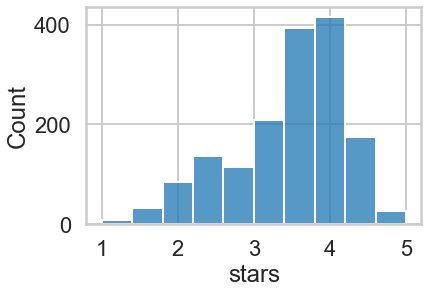

In [83]:
sns.histplot(meanstars,bins=10)

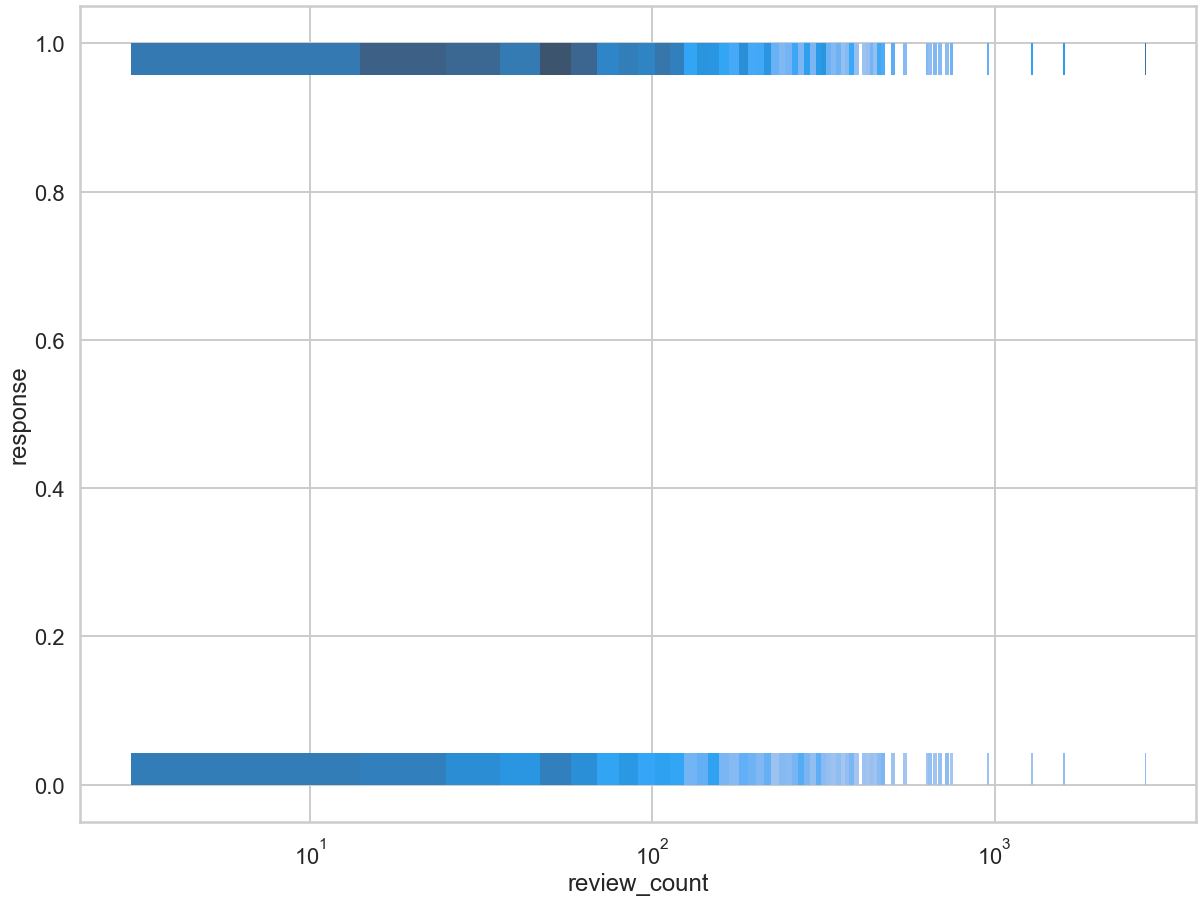

In [66]:
fig,ax=plt.subplots(figsize=(20,15))
sns.histplot(data=res,x='review_count',y='response')
ax.set_xscale("log")